In [46]:
#Installing & Importing necessary librariers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, timedelta

In [47]:
#Loading data
df = pd.read_csv("C:\\Users\\Admin\\Desktop\\Live Project\\2\\Data\\beverage_backup\\Beverage.csv")

In [48]:
#Drop unecessary column
df.drop(['Unnamed: 0','Co2', 'Date_coder', 'Day', 'Hour', 'Month', 'PSP', 'Palletizer', 'Plasmax', 'Preform', 'Uday', 'Week', 'Year', 'product'], axis = 1, inplace = True)

In [49]:
#Date & Time formatting
df['time'] = pd.to_datetime(df['time'], format= "%Y-%m-%d %H:%M:%S") 

In [50]:
#Making time as index
df.index = df['time']

In [51]:
#Aggregation by hour
df1 = df.resample('H').sum()
df1.head()

,Blower,Filler,Labeller
time,,,
2020-08-16 00:00:00+00:00,0.0,0.0,2.0
2020-08-16 01:00:00+00:00,0.0,0.0,0.0
2020-08-16 02:00:00+00:00,0.0,0.0,0.0
2020-08-16 03:00:00+00:00,0.0,0.0,0.0
2020-08-16 04:00:00+00:00,0.0,0.0,0.0


In [52]:
#Diving Blower values by 2 which ever exceeds 360000 bottles
df1['Blower'] = df1['Blower'].apply(lambda x: x/2 if x>=36000 else x)

In [53]:
#Creating train and test set 
train = df1[0:201] 
test = df1[201:]

In [54]:
blow_test = test.Blower
blow_train = train.Blower

In [55]:
blow_test.shape
blow_train.shape

(201,)

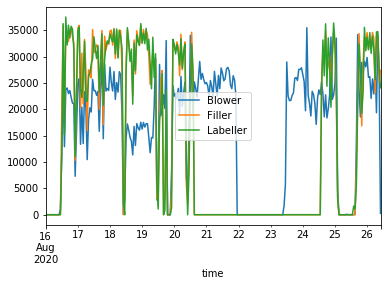

In [56]:
df1.plot()

In [57]:
### Testing For Stationarity
from statsmodels.tsa.stattools import adfuller

#The Dickey-Fuller test: It is used to determine the presence of unit root in a series, and hence help us to understand if the series is stationary or not.
#Ho: It is non stationary
#H1: It is stationary

In [58]:
test_result=adfuller(df1['Blower'])

In [59]:
#Ho: It is non stationary
#H1: It is stationary
def adfuller_test(Blower):
    result=adfuller(Blower)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [60]:
adfuller_test(df1['Blower'])

ADF Test Statistic : -3.704802278425481
p-value : 0.0040461106241147
#Lags Used : 2
Number of Observations Used : 248
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


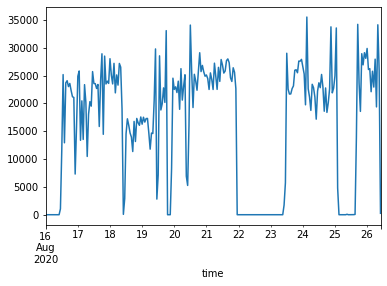

In [61]:
df1['Blower'].plot()

#ACF(auto-correlation function) : It describes how well the present value of the series is related to its past values.

#PACF(partial autocorrelation function) : Instead of finding correlations of present with lags like ACF, it finds the correlations of the residuals with the next lag value thus ‘partial’ and not ‘complete’ as we remove already found variations before we find next correlation.

In [62]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

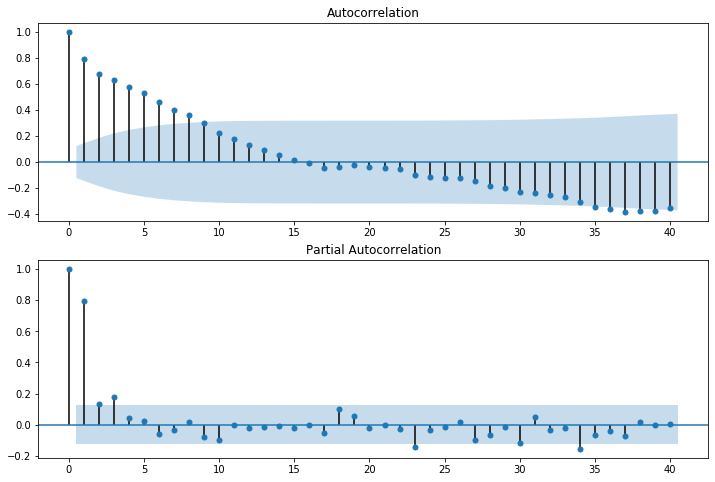

In [63]:
#fig = plt.figure(figsize=(12,8))
#ax1 = fig.add_subplot(211)
#fig = sm.graphics.tsa.plot_acf(df1['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
#ax2 = fig.add_subplot(212)
#fig = sm.graphics.tsa.plot_pacf(df1['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df1['Blower'].iloc[0:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df1['Blower'].iloc[0:],lags=40,ax=ax2)


ARIMA MODEL Auto Regression Integrated Moving Average It is specified by three parameters (p,d,q) Here, p is the order of the autoregressive model (number of time lags) d is the degree of differencing (no. of times the data have had passed values subtracted) q is the order of moving average model The ARIMA forecasting for a stationary time series is nothing but a linear (like linear regression) equation

In [64]:
# For non-seasonal data
#p=1, d=0, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA

In [71]:
#pqd
#ARIMA
blow_model = ARIMA(blow_train, order=(1,1,1))

In [72]:
blow_model_fit = blow_model.fit()

In [73]:
blow_model_fit.aic

4066.801060097675

In [74]:
blow_forecast = blow_model_fit.forecast(steps = 50)[0]

In [75]:
from sklearn.metrics import mean_squared_error
#from math import sqrt
import numpy as np

In [76]:
np.sqrt(mean_squared_error(blow_test,blow_forecast))

14729.155865529863

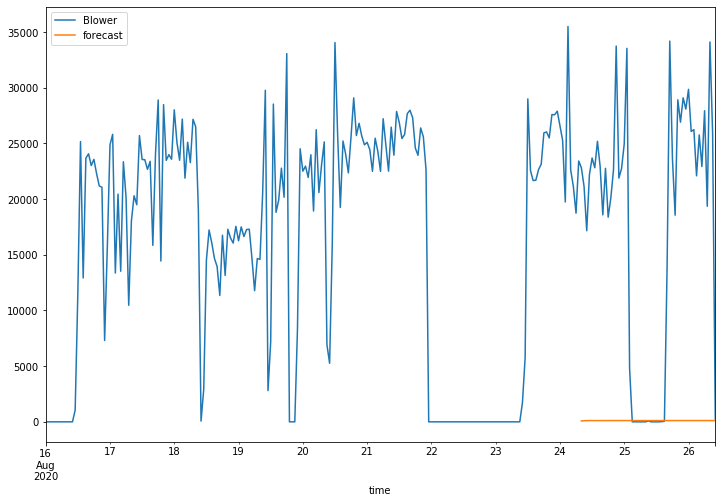

In [77]:
df1['forecast']=blow_model_fit.predict(start=200,end=250,dynamic=True)
df1[['Blower','forecast']].plot(figsize=(12,8))

#SARIMA

In [27]:
blower_model=sm.tsa.statespace.SARIMAX(blow_train,order=(1, 1, 1),seasonal_order=(1,1,1,24))

In [28]:
blower_model_fit = blower_model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [29]:
#results.summary()
blower_model_fit.aic

3593.713639316372

In [30]:
blower_forecast = blower_model_fit.forecast(steps = 50)

In [31]:
np.sqrt(mean_squared_error(blow_test,blower_forecast))

13115.200582157131

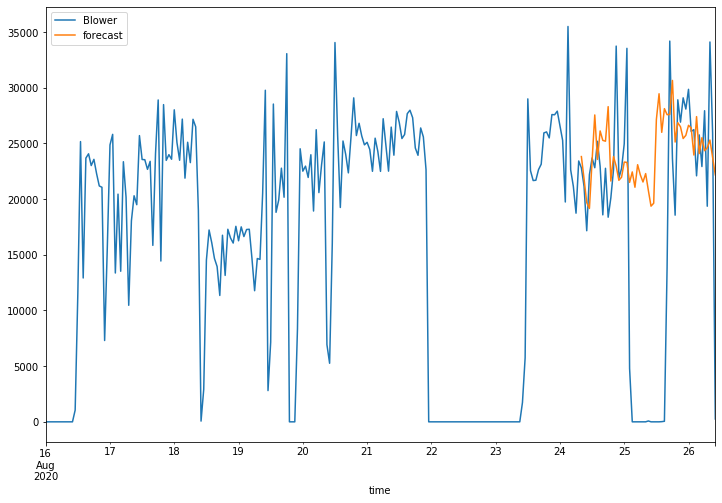

In [32]:
df1['forecast']=blower_model_fit.predict(start=200,end=251,dynamic=True)
df1[['Blower','forecast']].plot(figsize=(12,8))

In [33]:
from pandas.tseries.offsets import DateOffset
#future_dates=[df1.index[-1]+ DateOffset(hours=x)for x in range(0,24)]
future_dates=[df1.index[-1]+ DateOffset(hours=x)for x in range(0,50)]

In [34]:
future_datest_df1=pd.DataFrame(index=future_dates[1:],columns=df1.columns)

In [35]:
future_df1=pd.concat([df1,future_datest_df1])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2014: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


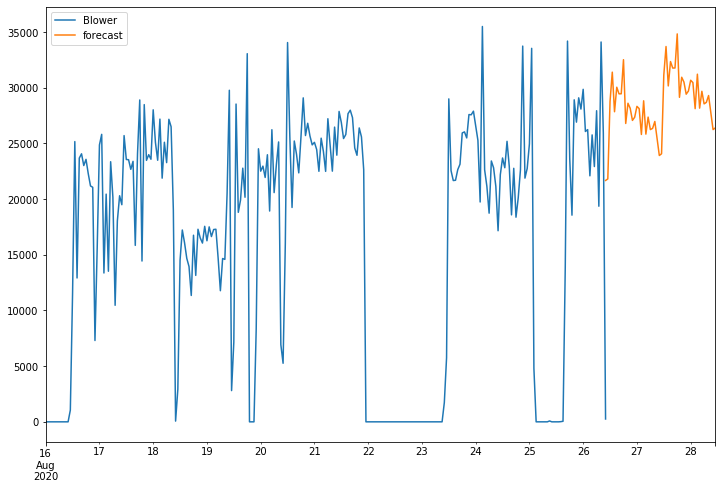

In [36]:
future_df1['forecast'] = blower_model_fit.predict(start = 250, end = 300, dynamic= True)  
future_df1[['Blower', 'forecast']].plot(figsize=(12, 8))

In [37]:
df2 = future_df1.forecast

In [38]:
df2.dropna(inplace = True)

In [39]:
df2 = df2.astype(dtype = 'int64')

In [40]:
future_df2=pd.concat([df1,df2])

In [41]:
future_df2

,Blower,Filler,Labeller,forecast,0
2020-08-16 00:00:00+00:00,0.0,0.0,2.0,NaN,NaN
2020-08-16 01:00:00+00:00,0.0,0.0,0.0,NaN,NaN
2020-08-16 02:00:00+00:00,0.0,0.0,0.0,NaN,NaN
2020-08-16 03:00:00+00:00,0.0,0.0,0.0,NaN,NaN
2020-08-16 04:00:00+00:00,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...
2020-08-28 07:00:00+00:00,NaN,NaN,NaN,NaN,28685.0
2020-08-28 08:00:00+00:00,NaN,NaN,NaN,NaN,29299.0
2020-08-28 09:00:00+00:00,NaN,NaN,NaN,NaN,27751.0
2020-08-28 10:00:00+00:00,NaN,NaN,NaN,NaN,26240.0


In [42]:
future_df2 = future_df2.drop('forecast', axis = 1)

In [43]:
future_df2.rename(columns={ 0 :'forecast'}, inplace=True)

In [44]:
import dtale

In [45]:
dtale.show(future_df2)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1102: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

